In [1]:
import tensorflow as tf
import math as m
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LeakyReLU
from tqdm import tqdm

tf.__version__

ModuleNotFoundError: ignored

(logging setup below is to suppress warnings about non-existent gradients)

In [4]:
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [5]:
if tf.test.is_gpu_available():
  device = tf.test.gpu_device_name()
else:
  print("GPU not found")
  device = "cpu"

# Forward Sampling

In [6]:
ANGLE = m.pi/2
LATENT_DIM = 4   # 4 angles
COND_DIM = 2     # 2 coordinates of end point
VARIANCES = [1./16., 1./4., 1./4., 1./4.]

In [7]:
def prior0(batchsize):
    return tf.expand_dims(tf.random.normal(shape=[batchsize], stddev=VARIANCES[0]),axis=-1)

def prior1(batchsize):
    return tf.expand_dims(tf.random.normal(shape=[batchsize], stddev=VARIANCES[1]),axis=-1)

def prior2(batchsize):
    return tf.expand_dims(tf.random.normal(shape=[batchsize], stddev=VARIANCES[2]),axis=-1)

def prior3(batchsize):
    return tf.expand_dims(tf.random.normal(shape=[batchsize], stddev=VARIANCES[3]),axis=-1)

def priors(bs):
    return tf.concat([prior0(bs), prior1(bs), prior2(bs), prior3(bs)], axis=-1)

In [8]:
def sample_forward(priors: callable, batchsize=1000, lengths: list = [1., 1., 1.], show_joints=True):
    angles = priors(batchsize)
    x = tf.cumsum(tf.cos(angles[:,1:]) * lengths, axis=-1)
    y = angles[:,0][..., None] + tf.cumsum(tf.sin(angles[:,1:]) * lengths, axis=-1)
    # add starting point
    x = tf.concat([tf.zeros(batchsize)[:, None], x], axis=-1)
    y = tf.concat([tf.zeros(batchsize)[:, None], y], axis=-1)
    if not show_joints:
        return angles, tf.concat([tf.expand_dims(x[:,-1], axis=-1),tf.expand_dims(y[:,-1], axis=-1)], axis=-1).numpy()
    return angles, tf.concat([tf.expand_dims(x, axis=-1),tf.expand_dims(y, axis=-1)], axis=-1).numpy()

def calc_points_from_angles(angles, lengths: list = [1., 1., 1.], show_joints=True):
    batchsize = angles.shape[0]
    x = tf.cumsum(tf.cos(angles[:,1:]) * lengths, axis=-1)
    y = angles[:,0][..., None] + tf.cumsum(tf.sin(angles[:,1:]) * lengths, axis=-1)
    # add starting point
    x = tf.concat([tf.zeros(batchsize)[:, None], x], axis=-1)
    y = tf.concat([tf.zeros(batchsize)[:, None], y], axis=-1)
    if not show_joints:
        return tf.concat([tf.expand_dims(x[:,-1], axis=-1),tf.expand_dims(y[:,-1], axis=-1)], axis=-1).numpy()
    return tf.concat([tf.expand_dims(x, axis=-1),tf.expand_dims(y, axis=-1)], axis=-1).numpy()

# Helper Networks

In [18]:
class CouplingNet(tf.keras.Model):
    def __init__(self, input_dim, dim_out):
        super().__init__()
        self.input_dim = input_dim
        self.dim_out = dim_out

        self.net = tf.keras.Sequential([
                tf.keras.Input(shape=self.input_dim),
                Dense(units=128, activation=LeakyReLU(alpha=0.01)),
                Dense(units=128, activation=LeakyReLU(alpha=0.01)),
                Dense(units=2*self.dim_out, activation="linear"), #outputs s and t for each dim
            ])

    def call(self, inputs):
        output = self.net(inputs)
        s, t = tf.split(output, [self.dim_out, self.dim_out], axis=-1)
        return tf.math.tanh(s), t

class Permutation(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim

        permutation_vec = np.random.permutation(latent_dim)
        inv_permutation_vec = np.argsort(permutation_vec)
        self.permutation = tf.Variable(initial_value=permutation_vec,
                                       trainable=False,
                                       dtype=tf.int32,
                                       name='permutation')
        self.inv_permutation = tf.Variable(initial_value=inv_permutation_vec,
                                           trainable=False,
                                           dtype=tf.int32,
                                           name='inv_permutation')

    def call(self, target, inverse=False):
        if not inverse:
            return tf.gather(target, self.permutation, axis=-1)
        return tf.gather(target, self.inv_permutation, axis=-1)

class ActNorm(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()

        self.latent_dim = latent_dim
        # checks whether actnorm has been called yet to initialize the values for with first mini-batch
        self.first_call = True

    def call(self, input, reverse=False):
        if not reverse:
            return self._forward(input)
        else: return self._inverse(input)

    def ljd(self):
        return float(self.scaling.shape[-1]) * tf.math.reduce_sum(tf.math_log(tf.math.abs(self.scaling)))

    def _forward(self, input):
        if self.first_call:
            vars = tf.math.reduce_variance(input, axis=1)
            self.scaling = tf.Variable(initial_value=vars, trainable=True)
            means = tf.math.reduce_mean(input, axis=1)
            self.offset = tf.Variable(initial_value=means, trainable=True)
            self.first_call = False
        return (input - self.offset[:, None]) / (self.scaling[:, None] + 1e-4)

    def _inverse(self, input):
        if self.first_call:
            raise Exception("At least one forward pass needs to be performed before calling the inverse of the network")
        return


# INN class

In [19]:
class INN(tf.keras.Model):
    def __init__(self, latent_dim, cond_dim, num_layers = 6):
        super().__init__()

        self.latent_dim = latent_dim
        self.cond_dim = cond_dim
        self.split_len1 = self.latent_dim // 2
        self.split_len2 = self.latent_dim - self.split_len1

        self.num_layers = num_layers
        self.coupling_nets1 = [CouplingNet(self.split_len2+self.cond_dim, self.split_len1) for _ in range(self.num_layers)]
        self.coupling_nets2 = [CouplingNet(self.split_len1+self.cond_dim, self.split_len2) for _ in range(self.num_layers)]
        self.permutations = [Permutation(self.latent_dim) for _ in range(self.num_layers)]

    def call(self, inputs, cond, inverse=False):
        if not inverse:
            return self._forward(inputs, cond)
        return self._inverse(inputs, cond)

    def _forward(self, x, cond):
        logjacdet = tf.zeros(x.shape[:-1])

        for layer in range(self.num_layers):
            u1, u2 = tf.split(x, [self.split_len1, self.split_len2], axis=-1)

            s1, t1 = self.coupling_nets1[layer](tf.concat([u2, cond], axis=-1))
            v1 = u1 * tf.exp(s1) + t1

            s2, t2 = self.coupling_nets2[layer](tf.concat([v1, cond], axis=-1))
            v2 = u2 * tf.exp(s2) + t2

            x = tf.concat([v1, v2], axis=-1)

            x = self.permutations[layer](x)

            logjacdet = logjacdet + tf.reduce_sum(tf.concat([s1, s2], axis=-1), axis=-1)
        z = x
        return z, logjacdet

    def _inverse(self, z, cond):
        for layer in range(self.num_layers-1, -1, -1):
            z = self.permutations[layer](z, inverse=True)

            v1, v2 = tf.split(z, [self.split_len1, self.split_len2], axis=-1)

            s2, t2 = self.coupling_nets2[layer](tf.concat([v1, cond], axis=-1))
            u2 = (v2 - t2) * tf.exp(-s2)

            s1, t1 = self.coupling_nets1[layer](tf.concat([u2, cond], axis=-1))
            u1 = (v1 - t1) *tf.exp(-s1)

            z = tf.concat([u1, u2], axis=-1)
        x = z
        return x

# Training

In [11]:
def forward_loss(model, x, cond):
    z_pred, ljd = model(x, cond, inverse=False)
    z_loss = 0.5 * tf.reduce_sum(z_pred**2, axis=-1)
    return tf.reduce_sum(z_loss - ljd)

In [12]:
def grad(model, x, cond):
    with tf.GradientTape() as tape:
        loss_value = forward_loss(model, x, cond)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [13]:
def initialize_INN(INN, latent_dim=LATENT_DIM, cond_dim=COND_DIM):
    """initialize INN until it produces non-NaN outputs"""
    trainingINN = INN(latent_dim=latent_dim, cond_dim=cond_dim)
    angles, points = sample_forward(priors=priors, lengths=[1., 1., 1.], batchsize=1000, show_joints=False)
    while np.isnan(forward_loss(trainingINN, angles, points).numpy()):
        trainingINN = INN(latent_dim=latent_dim, cond_dim=cond_dim)
    return trainingINN

In [41]:
def train_INN(batch_size = 1000, epochs = 1000, init=True, pretrained_model=None):
    with tf.device(device):
        if init:
            inn = initialize_INN(INN)
        else: inn = pretrained_model

        train_loss_results = []
        train_accuracy_results = []
        training_optimizer = tf.keras.optimizers.Adagrad()

        angles, points = sample_forward(priors=priors, lengths=[1., 1., 1.], batchsize=1000, show_joints=False)
        loss_value, grads = grad(inn, angles, points)
        print(f"Step {training_optimizer.iterations.numpy()}, Initial Loss: {loss_value.numpy()}")
        min_loss=0
        best_model = inn
        for epoch in tqdm(range(epochs)):
            if np.isnan(forward_loss(inn, angles, points).numpy()):
                return best_model
            angles, points = sample_forward(priors=priors, lengths=[1., 1., 1.], batchsize=batch_size, show_joints=False)
            loss_value, grads = grad(inn, angles, points)
            if loss_value < min_loss:
                min_loss = loss_value
                best_model = inn
            training_optimizer.apply_gradients([
                                            (gradient, var)
                                            for (gradient, var) in zip(grads, inn.trainable_variables)
                                            if grad is not None])
            if training_optimizer.iterations.numpy()%(epochs/10) == 0:
                print(f"Step {training_optimizer.iterations.numpy()},         Loss: {forward_loss(inn, angles, points).numpy()}")
            train_loss_results.append(forward_loss(inn, angles, points).numpy())
            plt.plot(train_loss_results)
            plt.draw()

    return best_model

Step 0, Initial Loss: 6111.6396484375


 10%|█         | 100/1000 [00:39<04:53,  3.06it/s]

Step 100,         Loss: -6783.234375


 20%|██        | 200/1000 [01:14<04:52,  2.73it/s]

Step 200,         Loss: -7278.74853515625


 30%|███       | 300/1000 [01:52<04:29,  2.59it/s]

Step 300,         Loss: -7036.21240234375


 40%|███▉      | 399/1000 [02:34<04:42,  2.13it/s]

Step 400,         Loss: -6843.79248046875


 50%|████▉     | 499/1000 [03:23<04:27,  1.87it/s]

Step 500,         Loss: -7791.69384765625


 60%|█████▉    | 599/1000 [04:21<05:02,  1.32it/s]

Step 600,         Loss: -8039.2353515625


 70%|██████▉   | 699/1000 [05:29<03:30,  1.43it/s]

Step 700,         Loss: -8387.7265625


 80%|███████▉  | 799/1000 [06:47<02:43,  1.23it/s]

Step 800,         Loss: -8025.125


 90%|████████▉ | 899/1000 [08:17<01:46,  1.05s/it]

Step 900,         Loss: -8163.724609375


100%|█████████▉| 999/1000 [10:01<00:01,  1.08s/it]

Step 1000,         Loss: -8550.1611328125


100%|██████████| 1000/1000 [10:02<00:00,  1.66it/s]


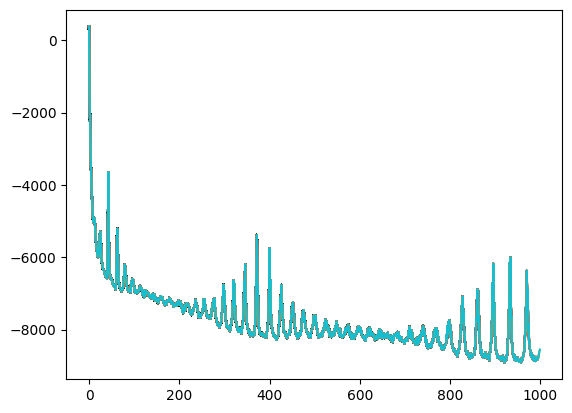

In [42]:
test_model = train_INN()

In [23]:
test_model

# Testing

100%|██████████| 1000/1000 [01:11<00:00, 14.00it/s]


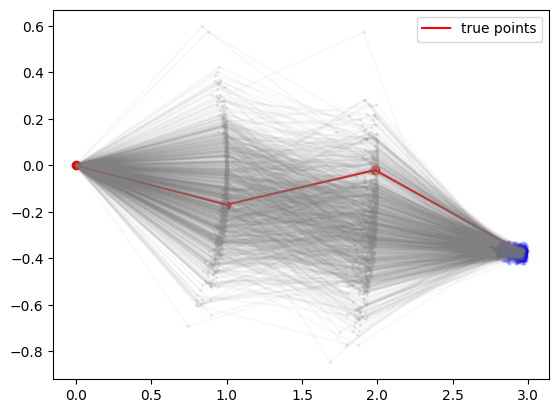

In [44]:
angles, points = sample_forward(priors=priors, lengths=[1., 1., 1.], batchsize=1, show_joints=True)
plt.scatter(points[0,:,0], points[0,:,1], color=[1,0,0])
plt.plot(points[0,:,0], points[0,:,1], label="true points", color=[1,0,0])

for i in tqdm(range(1000)):
    pred_angles = test_model(inputs=tf.random.normal((1,4)), cond=points[:,-1,:], inverse=True)
    pred_points = calc_points_from_angles(pred_angles)

    plt.scatter(pred_points[0,-1,0], pred_points[0,-1,1], alpha=.2, color=[0,0,1], s=5)
    plt.scatter(pred_points[0,:-1,0], pred_points[0,:-1,1], alpha=.2, color=[.7,.7,.7], s=2)
    plt.plot(pred_points[0,:,0], pred_points[0,:,1], alpha=.05, color=[.5,.5,.5])

plt.legend()
plt.show()

# Save Weights

trainingINN.save_weights('./checkpoints/my_checkpoint')

# Load Weights

trainingINN.load_weights('./checkpoints/my_checkpoint')